In [2]:
import numpy as np

import requests 
import json 
import pandas as pd 
import string 
import re 
import matplotlib.pyplot as plt 
import sklearn 
from sklearn.metrics import confusion_matrix , accuracy_score , f1_score
import pickle

# REDDIT DATA COLLECTION

#### I used PUSHSHIFT.IO API instead of PRAW as praw had certain limits on the number of data values. PRAW doesn't provide access to more than 1000 records

In [3]:
def getPushshiftData(sub=None, before=None, after=None, ids=None, getSubmissions=True, getComments=False):
    suffix=''
    searchType = 'submission'
    if getComments or not getSubmissions:
        searchType='comment'
    if (before is not None):
        suffix += '&before='+str(before)
    if (after is not None):
        suffix += '&after='+str(after)
    if (sub is not None):
        suffix += '&subreddit='+sub
    if (ids is not None):
        suffix += '&ids='+','.join(ids)

    url = 'https://api.pushshift.io/reddit/search/'+searchType+'?sort=desc&size=1500'+suffix
    print('loading '+url)
    r = requests.get(url)
    data = json.loads(r.content)
    if len(data['data']) > 0:
        prev_end_date = data['data'][-1]['created_utc']
    else:
        prev_end_date = None
    return (data, prev_end_date)

#### The time have been set to 120 days which results in collection of around 50000-60000 titles

In [4]:
sub='India'
(submissions_tmp, prev_end_date) = getPushshiftData(sub=sub, after='120d')
submissions = submissions_tmp['data']
while prev_end_date is not None:
    try:
        (submissions_tmp, prev_end_date) = getPushshiftData(sub=sub, before=prev_end_date-1, after='120d')
        if prev_end_date is not None:
            submissions.extend(submissions_tmp['data'])
    except:
        continue

loading https://api.pushshift.io/reddit/search/submission?sort=desc&size=1500&after=120d&subreddit=India
loading https://api.pushshift.io/reddit/search/submission?sort=desc&size=1500&before=1587715723&after=120d&subreddit=India
loading https://api.pushshift.io/reddit/search/submission?sort=desc&size=1500&before=1587535750&after=120d&subreddit=India
loading https://api.pushshift.io/reddit/search/submission?sort=desc&size=1500&before=1587367144&after=120d&subreddit=India
loading https://api.pushshift.io/reddit/search/submission?sort=desc&size=1500&before=1587208812&after=120d&subreddit=India
loading https://api.pushshift.io/reddit/search/submission?sort=desc&size=1500&before=1587042681&after=120d&subreddit=India
loading https://api.pushshift.io/reddit/search/submission?sort=desc&size=1500&before=1586870887&after=120d&subreddit=India
loading https://api.pushshift.io/reddit/search/submission?sort=desc&size=1500&before=1586708430&after=120d&subreddit=India
loading https://api.pushshift.io/r

In [5]:
submission =[]
for post in submissions:
    submission.append(post)
submission

[{'all_awardings': [],
  'allow_live_comments': False,
  'author': 'All_Indian_Festivals',
  'author_flair_css_class': None,
  'author_flair_richtext': [],
  'author_flair_text': None,
  'author_flair_type': 'text',
  'author_fullname': 't2_69rnln2o',
  'author_patreon_flair': False,
  'author_premium': False,
  'awarders': [],
  'can_mod_post': False,
  'contest_mode': False,
  'created_utc': 1587914013,
  'domain': 'self.india',
  'full_link': 'https://www.reddit.com/r/india/comments/g8fzcr/know_what_when_why_and_how_to_celebrate_all/',
  'gildings': {},
  'id': 'g8fzcr',
  'is_crosspostable': True,
  'is_meta': False,
  'is_original_content': False,
  'is_reddit_media_domain': False,
  'is_robot_indexable': True,
  'is_self': True,
  'is_video': False,
  'link_flair_background_color': '#5093d6',
  'link_flair_css_class': 'Non-Political',
  'link_flair_richtext': [{'e': 'text', 't': 'Non-Political'}],
  'link_flair_template_id': '8f105a84-7ea0-11e3-bba1-12313b0c91be',
  'link_flair_t

In [6]:
submission_df=pd.DataFrame(submission)

In [7]:
df1 = pd.concat([submission_df['title'],submission_df['link_flair_text']], axis = 1)

# Exploratory Data Analysis

In [8]:
df1 = df1.dropna()

In [9]:
pd.set_option('display.max_colwidth', 100)
df = df1.copy()
df['flair'] = df['link_flair_text']
df= df.drop(['link_flair_text'], axis = 1)
df

title  \
0                                         Know What, When, Why and How to celebrate All Indian Festivals ?   
1                                 Is it a good idea to pursue masters in U.S. given the current situation?   
2                                           TEJAS Aircraft Aerodynamics Analysis - The Swedish Connection?   
3                             Helo barred anti Chinese government content, company says no restriction now   
4      Covid-19 lockdown: Jain community delivers free meals, medicine to needy in Delhi | Delhi News -...   
...                                                                                                    ...   
58663  "The government wants the youth to think that protesting is anti national. But what they don't w...   
58665                            UP Cops Stop Priyanka Gandhi En Route Activist Home, She Rides On Scooter   
58666                          RULER - Yaala Yaala Full Song in Keyboard by Pratish| Nandamuri Balakris...   
58667                       How to shut down a right-wing troll without name-calling. Details in comments.   
58668                                                                            Look what they are saying   

                    flair  
0           Non-Political  
1                AskIndia  
2      Science/Technology  
3                Politics  
4             Coronavirus  
...                   ...  
58663            Politics  
58665            Politics  
58666       Non-Political  
58667            Politics  
58668       Non-Political  

[44752 rows x 2 columns]

In [10]:
flair_set = set(df['flair'])

In [11]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [12]:
df.groupby('flair').count()['title'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8,
                                                           title='Bar chart of Department Name', xTitle='Department Name')

##### IT WAS FOUND THAT THE DATA WAS HIGHLY BIASED .
MORE THAN 50% DATA WAS COMPRISED OF JUST 4 CLASSES.
SEPERATED THE 10 MOST FREQUENT FLAIRS & ENLISTED THEM IN LIST CALLED FLAIR2KEEP .
ALL OTHER CLASSES WERE DROPPED AS IT WOULD BE DIFFICULT FOR THE MODEL TO WORK WITH SO MANY CLASSES

In [13]:
flairs2keep = df1['link_flair_text'].value_counts()[:10].index.tolist()
flairs2keep

['Politics',
 'Non-Political',
 'Coronavirus',
 'AskIndia',
 'Policy/Economy',
 'Science/Technology',
 'Business/Finance',
 'CAA-NRC',
 'Photography',
 'Food']

In [14]:
for f in flair_set:
    if f not in flairs2keep:
        df = df[df.flair != f]
    else :
        continue

In [15]:
set(df['flair'])

{'AskIndia',
 'Business/Finance',
 'CAA-NRC',
 'Coronavirus',
 'Food',
 'Non-Political',
 'Photography',
 'Policy/Economy',
 'Politics',
 'Science/Technology'}

### BALANCING THE BIASED DATA

##### It was observed that the data collected was biased. On analysing the number of count 

##### i found that the class with minimum count had 500(appx) values whereas the rest lower 5 varied from 1000-1500. I decided it would be fair enough to resample the data to a value of 2000 per class.

#####  2000 DATA VALUES FROM EACH CLASS WERE EXPLICILY TAKEN BY PERFORMING OVER OR UNDERSAMPLING ACCORDINGLY

In [16]:
flairs_count = {'flair' : [] , 'count' : []}
for flair in flairs2keep:
    count = np.sum(df.loc[:, 'flair'].values == flair)
    flairs_count['flair'].append(flair)
    flairs_count['count'].append(count)
pd.DataFrame(flairs_count)

flair  count
0            Politics  10994
1       Non-Political   9274
2         Coronavirus   8853
3            AskIndia   5943
4      Policy/Economy   1670
5  Science/Technology   1592
6    Business/Finance   1500
7             CAA-NRC   1070
8         Photography    992
9                Food    508

In [17]:
corona_df = df[df.flair == 'Coronavirus']
np_df     = df[df.flair == 'Non-Political']
p_df      = df[df.flair == 'Politics']
ask_df    = df[df.flair == 'AskIndia']
food_df   = df[df.flair == 'Food']
tech_df   = df[df.flair == 'Science/Technology']
econ_df   = df[df.flair == 'Policy/Economy']
fin_df    = df[df.flair == 'Business/Finance']
caa_df    = df[df.flair == 'CAA-NRC']
photo_df  = df[df.flair == 'Photography']

In [18]:
from sklearn.utils import resample

corona_bal = resample(corona_df,
                          replace = False, 
                          n_samples = 2000, 
                          random_state = 27)
np_bal = resample(np_df,
                          replace = False,
                          n_samples = 2000, 
                          random_state = 27)
p_bal = resample(p_df,
                          replace = False, 
                          n_samples = 2000, 
                          random_state = 27)
ask_bal = resample(ask_df,
                          replace = False, 
                          n_samples = 2000, 
                          random_state = 27)

photo_bal =  resample(photo_df,
                          replace = True, 
                          n_samples = 2000, 
                          random_state = 27)
food_bal  =  resample(food_df,
                          replace = True, 
                          n_samples = 2000, 
                          random_state = 27)
tech_bal  =  resample(tech_df,
                          replace = True, 
                          n_samples = 2000, 
                          random_state = 27)
econ_bal = resample(econ_df,
                          replace = True,
                          n_samples = 2000, 
                          random_state = 27)
fin_bal = resample(fin_df,
                          replace = True, 
                          n_samples = 2000, 
                          random_state = 27)
caa_bal = resample(caa_df,
                          replace = True, 
                          n_samples = 2000,
                          random_state = 27)



In [19]:
df_2 = pd.concat([caa_bal,econ_bal,fin_bal,tech_bal,food_bal,ask_bal,photo_bal,p_bal,np_bal,corona_bal ])

In [20]:
flairs_count = {'flair' : [] , 'count' : []}
for flair in flairs2keep:
    count = np.sum(df_2.loc[:, 'flair'].values == flair)
    flairs_count['flair'].append(flair)
    flairs_count['count'].append(count)
pd.DataFrame(flairs_count)

flair  count
0            Politics   2000
1       Non-Political   2000
2         Coronavirus   2000
3            AskIndia   2000
4      Policy/Economy   2000
5  Science/Technology   2000
6    Business/Finance   2000
7             CAA-NRC   2000
8         Photography   2000
9                Food   2000

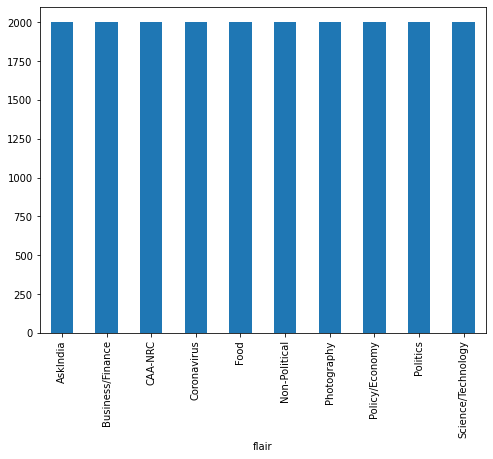

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_2.groupby('flair').title.count().plot.bar(ylim=0)
plt.show()

In [22]:
df_3 = df.copy()
df = df_2

## PREPROCESSING

#####  AS A PART OF PREPROCESSING
NUMBERS , PUNCTUATIONS , EMOJIS , STOPWORDS WERE REMOVED FROM THE TEXT.
LEMMATIZATION OF TEXT WAS DONE INSTEAD OF STEMMING. ALSO, TOKENIZATION OF DATA WAS ALSO DONE

I USED REGULAR EXPRESSIONS & NLTK LIBRARY TO PREPROCESS THE DATA

I prefered lemmatization over because stemmers reduce the word to its root form by removing the suffix and the result may or may not hold meaning whereas lemmatizatio resulted in meaniful root words.

I had to use these words to use glove embedding further in the process therefore the words had to meaningful moreove lemmatizers also keep track of synonyms therefore reducing the dimensionality

In [23]:
def no_num(text):
    text = re.sub('[0-9]+', '', text)
    return text

def no_punc(text):
    #nopuncmsg = ''.join([c for c in text if c not in string.punctuation])
    text = re.sub(r'[^\w\s]',' ',text)
    text = re.sub(' +', ' ', text)
    return text

In [24]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

In [25]:
tokenized = []
def tokenizer(text):
    tokenized = word_tokenize(text)
    return tokenized
remov_stop_words = []
def remov_stopwords(text):
    remov_stop_words  =' '.join([c for c in text.split(' ') if c not in stopwords.words('english')])
    return remov_stop_words
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
def func_lemmatizer(text):
    lemmatized = []
    lemmatizer = WordNetLemmatizer()
    lemmatized = ' '.join( [ lemmatizer.lemmatize(word) for word in text] )
    return lemmatized

In [26]:
index_perm = np.random.permutation(df.index)

In [27]:
df = df.sample(frac=1).reset_index(drop=True)
df.head(20)

title  \
0                                                        Indira Gandhi wasted money on waste management   
1   RBI announces Long Term Repo Operations to address Liquidity issues:decides to conduct Targeted ...   
2                 Why Is the Centre Pushing a New Electricity Bill in the Midst of the COVID-19 Crisis?   
3                                        why web development services is important for Indian company ?   
4   Human Resource Development Ministry in Lok Sabha: UGC has informed that, at present, 18243 teach...   
5                                         Delhi Court Grants Bail to Shaheen Bagh Shooter Kapil Baisala   
6                                                               Good NRO accounts with internet banking   
7   Railways transports 20 litres of camel milk to a family in Mumbai after a woman tweeted about it...   
8                                               Anxiously Yours - Rohan Joshi | Spoken Fest Mumbai 2020   
9                                                          The Production of Violence in Delhi [ Video]   
10                                India Has Worst Economy In 42 Years. Is Prime Minister Modi Watching?   
11                                                                                     Smartphone Gyaan   
12                                                     UPCOMING WHATSAPP UPDATES IN 2020 - societykarma   
13                                                                  ISO 45001 – Knowledge and Awareness   
14   Jamiat Ulema-e-Hind Moves SC, Says Tablighi Jamaat Event Being Used to ‘Demonise’ Muslim Community   
15  Tahir Hussain arrested. Kapil Mishra gets Y plus security, Anurag Thakur is free, no one seeking...   
16                                                  The Coronavirus explained &amp; what you should do.   
17                      Is it a bad idea to order food online in Delhi during the Coronavirus epidemic?   
18                                                                  Terror attack on Gurudwara in Kabul   
19                            Do students at University\college\highschool have to pay to do the exams?   

                 flair  
0       Policy/Economy  
1       Policy/Economy  
2       Policy/Economy  
3             AskIndia  
4             Politics  
5              CAA-NRC  
6     Business/Finance  
7          Coronavirus  
8        Non-Political  
9              CAA-NRC  
10    Business/Finance  
11  Science/Technology  
12  Science/Technology  
13    Business/Finance  
14       Non-Political  
15             CAA-NRC  
16         Coronavirus  
17                Food  
18            Politics  
19            AskIndia

In [28]:
text = df['title']

In [29]:
def preprocessor(text):
    text = text.str.lower()
    text = text.apply(no_num)
    text = text.apply(no_punc)
    text = text.apply(remov_stopwords)
    text = text.apply(deEmojify)
    text = text.apply(tokenizer)
    text = text.apply(func_lemmatizer)
    return text

In [30]:
text = preprocessor(df['title'])
df['title'] = text
df

title  \
0                                                              indira gandhi wasted money waste management   
1      rbi announces long term repo operation address liquidity issue decides conduct targeted long ter...   
2                                                   centre pushing new electricity bill midst covid crisis   
3                                                         web development service important indian company   
4      human resource development ministry lok sabha ugc informed present teaching amp non teaching pos...   
...                                                                                                    ...   
19995                                                                                          dhal makhni   
19996                                                                             finding aap ad godi news   
19997                            receiving full support andhra govt kia motor denies report shifting plant   
19998                                                           old india preparing welcome trump february   
19999                                       imported food coronavirus hit nation safe avoid raw meat fssai   

                flair  
0      Policy/Economy  
1      Policy/Economy  
2      Policy/Economy  
3            AskIndia  
4            Politics  
...               ...  
19995            Food  
19996        Politics  
19997  Policy/Economy  
19998        Politics  
19999            Food  

[20000 rows x 2 columns]

##### I MADE MY OWN DICTIONARY WHICH WAS FURTHER USED IN BUILDING LSTM LANGUAGE MODEL. THE MODEL SCRAPES THROUGH THE WHOLE TEXT AND ASSIGNS AN INDEX TO EACH UNIQUE WORD & ALSO MANTAING THE WORD COUNT

In [31]:
SOS_token = 0
EOS_token = 1
word2count = {}
word2index = {}
index2word = {}
n_words =  [0]

In [32]:
def addword(word , n_words , word2count , word2index , index2word ):
    if word not in word2index:
        word2index[word] = n_words[0]
        index2word[ n_words[0] ] = word
        word2count[word] = 1
        n_words[0] = n_words[0] + 1
    else:
        word2count[word] +=1

def addtext( sentence ,n_words , word2count , word2index , index2word ):
        for word in sentence.split(' '):
            addword(word , n_words , word2count , word2index , index2word )

In [33]:
df_1 = df.copy()
df_1['title'] = df_1['title'].apply( addtext , args = (n_words , word2count , word2index , index2word) )

In [34]:
len(word2index)

15391

#### SEPERATE DICTIONARY FOR FLAIRS

In [35]:
index2flair={}
flair2index ={}
for k , flair in enumerate(set(df['flair'])):
    index2flair[k] = flair
    flair2index[flair] = k

In [36]:
flair2index

{'Non-Political': 0,
 'Photography': 1,
 'Business/Finance': 2,
 'AskIndia': 3,
 'Politics': 4,
 'Coronavirus': 5,
 'CAA-NRC': 6,
 'Policy/Economy': 7,
 'Science/Technology': 8,
 'Food': 9}

## ML MODELS

In [37]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer , TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB , MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, linear_model, metrics

In [38]:
target_index = []
target_names = []

In [39]:
for flair in df['flair']:
    target_index.append(flair2index[str(flair)])
    target_names.append(flair)

In [40]:
corpus = []
for title in df['title']:
    corpus.append(title)

#### SPLITTING DATA FOR TESTING AND TRAINING . I TOOK ONLY 20% DATA AS TESTING DATA. AS I ALREADY HAD LESS DATA

In [41]:
train_x , test_x , train_y , test_y = train_test_split(corpus , target_names , test_size = 0.2)

### COUNTER VECTORIZER

IS A LIBRARY WHICH GIVES A DICTIONARY , VOCABULARY , WORD COUNTS OF THE CORPUS(INPUT) AS OUTPUT.

In [42]:
cv = CountVectorizer()
X = cv.fit(train_x)
print("vocab" , X.vocabulary_)
print("features" , X.get_feature_names())
counts = cv.transform(train_x)
print(counts.shape)
print(counts.toarray())

vocab {'anti': 599, 'nationalist': 8429, 'peacefully': 9270, 'protesting': 9941, 'law': 7133, 'ruled': 10887, 'meme': 7843, 'made': 7482, 'science': 11187, 'gang': 4929, 'maxepe': 7766, 'india': 6075, 'top': 12911, 'country': 2812, 'highest': 5600, 'tourist': 12937, 'inflow': 6146, 'lullaby': 7437, 'composed': 2537, 'nephew': 8520, 'feeling': 4498, 'exceptionally': 4268, 'stressed': 12187, 'news': 8553, 'lately': 7106, 'please': 9508, 'listen': 7291, 'tell': 12662, 'think': 12770, 'intelligent': 6265, 'pup': 10005, 'turn': 13132, 'police': 9569, 'station': 12089, 'missing': 8010, 'dog': 3668, 'patriotpress': 9229, 'ibm': 5866, 'advertisement': 229, 'indian': 6081, 'gave': 4973, 'world': 14023, 'algebra': 386, 'stay': 12096, 'home': 5691, 'shaheen': 11382, 'bagh': 1062, 'protester': 9940, 'ready': 10322, 'meet': 7818, 'shah': 11379, 'mha': 7902, 'say': 11148, 'meeting': 7819, 'scheduled': 11179, 'current': 2981, 'electric': 3980, 'tractor': 12956, 'innovation': 6191, 'pakistan': 9063, '

##### I USED PICKLE TO SAVE THE TRAINED MODEL & LOAD IT WHEN REQUIRED.

In [43]:
Pkl_Filename = "Pickle_CV_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(cv, file)

### TFIDF TRANSFORMER

ASSIGNS WEIGHTS TO THE WORDS ACCORDING TO THEIR FREQUENCY IN THE TEXT.
SO IF STOP WORDS LEFT WILL BE GIVEN THE MOST WEIGHTAGE

In [44]:
tf = TfidfTransformer()
X_tfidf = tf.fit_transform(counts)
print('learning frequency of all features :' + str(tf.idf_) + '\n\n')
freq = tf.transform(counts)
print(freq.toarray())

learning frequency of all features :[9.98725932 9.58179421 9.98725932 ... 9.98725932 9.58179421 9.58179421]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##### SAVING THE TFIDF MODEL ON PICKLE

In [45]:
Pkl_Filename = "Pickle_TF_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(tf, file)

#### I TRIED TO PREDICT WHICH MODEL WILL WORK BETTER ON THE FOLLOWING DATA

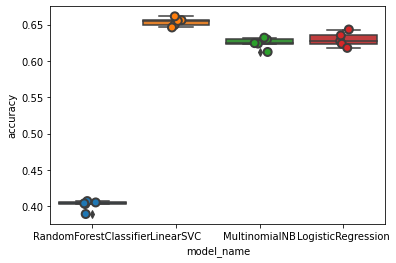

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0 , max_iter = 5000),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_tfidf, train_y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [47]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.653813
LogisticRegression        0.629625
MultinomialNB             0.624625
RandomForestClassifier    0.401812
Name: accuracy, dtype: float64

### LOGISTIC REGRESSION

ASSGNS OBSERVATIONS FOR DISCRETE CLASSES .
IT IS BASED ON STATISTICAL APPROACHES & IS VULNERABLE TO OVERFITTING BECAUSE OF IT

In [48]:
lr = LogisticRegression(max_iter = 5000)
x_lr = lr.fit(X_tfidf, train_y)
x_test_tf = cv.transform(test_x)
x_test_tfidf = tf.transform(x_test_tf)
predicted = lr.predict(x_test_tfidf)
print("accuracy : ", accuracy_score(test_y,predicted) )
print(metrics.classification_report(test_y,predicted , target_names = set_flair))
metrics.confusion_matrix(test_y , predicted)

accuracy :  0.64275


NameError: name 'set_flair' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np



data = confusion_matrix(test_y, predicted)
df_cm = pd.DataFrame(data, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})#

##### THE FOLLOWING GRAPHS SHOWS THE CONFUSION MATRIX OF THE ACTUAL RESULTS & PREDICTIONS

###  MULTINOMIAL NAIVE BAYES

I STARTED WITH NAIVE BAYES AS BASE MODEL FOR CLASSIFICATION. 
NAIVE BAYES IS A PROBABILISTIC APPROACH AND CONSIDERS EVERY FEATURE INDEPENDENT OF THE OTHER. 

In [ ]:
clf = MultinomialNB().fit(X_tfidf,train_y)

In [ ]:
Pkl_Filename = "Pickle_NB_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)

In [ ]:
set_flair = []
for f in set(test_y):
    set_flair.append(f)

In [ ]:
x_test_tf = cv.transform(test_x)
x_test_tfidf = tf.transform(x_test_tf)
predicted = clf.predict(x_test_tfidf)

In [ ]:
print("accuracy : ", accuracy_score(test_y,predicted) )
print(metrics.classification_report(test_y,predicted , target_names = set_flair))
metrics.confusion_matrix(test_y , predicted)

In [ ]:
data = confusion_matrix(test_y, predicted)
df_cm = pd.DataFrame(data, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})#

##### THE FOLLOWING GRAPHS SHOWS THE CONFUSION MATRIX OF THE ACTUAL RESULTS & PREDICTIONS

### Linear SVM

SUPPORT VECTOR MACHINE IS A GEOMETRIC APPROACH AND CONSIDERS ALL FEATURES DEPENDENT TO EACH OTHER. HENCE , IT CONSIDERS THE RELATION BETWEEN DIFFERENT FEATURES & HENCE IMPROVING THE RESULT

In [ ]:
lsvm = LinearSVC().fit(X_tfidf, train_y)

In [ ]:
x_test_tf = cv.transform(test_x)
x_test_tfidf = tf.transform(x_test_tf)
predicted = lsvm.predict(x_test_tfidf)

In [ ]:
print("accuracy : ", accuracy_score(test_y,predicted) )
print(metrics.classification_report(test_y,predicted , target_names = set_flair))
metrics.confusion_matrix(test_y , predicted)

In [ ]:
Pkl_Filename = "Pickle_SVM_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(lsvm, file)

In [ ]:
data = confusion_matrix(test_y, predicted)
df_cm = pd.DataFrame(data, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})#

##### THE FOLLOWING GRAPHS SHOWS THE CONFUSION MATRIX OF THE ACTUAL RESULTS & PREDICTIONS

### RANDOM FOREST MODEL

FOR EXPLAINABILITY AS RFC MODELS MEASURE THE WEIGHTAGE OF EACH WORD FOR EACH CLASS .  THEREFORE , ACCURACY OF THIS MODEL IS MANY TIMES BETTER.

In [ ]:
cv = CountVectorizer()
rfc_x = cv.fit_transform(train_x)
rfc= RandomForestClassifier()
rfc.fit(rfc_x, train_y)

In [ ]:
x_test_tf = cv.transform(test_x)
predicted = rfc.predict(x_test_tf)
print("accuracy : ", accuracy_score(test_y,predicted) )
print(metrics.classification_report(test_y,predicted , target_names = set_flair))
metrics.confusion_matrix(test_y , predicted)

In [ ]:
data = confusion_matrix(test_y, predicted)
df_cm = pd.DataFrame(data, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})#

##### THE FOLLOWING GRAPHS SHOWS THE CONFUSION MATRIX OF THE ACTUAL RESULTS & PREDICTIONS

In [ ]:
Pkl_Filename = "Pickle_RFC_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(rfc, file)

####  I WILL BE USING NAIVE BAYES , LINEAR SVM , RANDOM FOREST FOR PREDICTING THE OUTPUT IN THE FINAL MODEL

#### I BUILT A HYBRID MODEL WHERE I CONSIDER THE PROBABILITY OF OUTPUT OF EACH MODEL & THE MODEL, WITH MOST PROBABILITY OR THE MODEL WHICH IS MOST CONFIDENT ABOUT THE OUTPUT . ONLY THAT MODEL'S OUPUT WOULD BE RETURED.

# LSTM LANGUAGE MODEL

#####  INSTEAD OF MAKING MY OWN EMBEDDINGS .
##### I PREFERED USING GLOVE EMBEDDINGS DEVELOPED BY STANFORD NLP WHICH WAS TRAINED ON MILLIONS OF DATA WHICH ENSURED A BETTER EMBEDDING.

In [ ]:
file = "/home/aaryan/Documents/Research/ELMO 1/glove.6B.50d.txt"
import numpy as np
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    
     
    with open(gloveFile, encoding="utf8" ) as f:
        content = f.readlines()
    model = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
     
     
model= loadGloveModel(file)   
 
print (model['hello'])

In [ ]:
import csv 
words = pd.read_table(file, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
def vec(w):
    return words.loc[w].to_numpy()

 
print (vec('hello')) 

In [ ]:
#word_matrix = word.tonumpy()

##### TO BE USED GLOVE EMBEDDING FIRST HAS TO BE CONVERTED IN A FORM OF MATRIX :GLOVE WEIGHT MATRIX . WORD EMBEDDINGS OF EACH WORD IS SAVED IN THE MATRIX ACCORDING TO THEIR INDEXES IN THE DICTIONARY

In [ ]:
matrix_len = len(word2index)
weights_matrix = np.zeros((matrix_len , 50))
words_found = 0

for i , word in enumerate(word2index):
    try:
        weights_matrix[i] = words.loc[str(word)] 
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6 , size = (weights_matrix.shape[1], ))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
num_cases = df.shape[0]
num_cases

#### STANDARD DATASET OF TEXT WITH LISTS ENLISTED WITH INDEXES OF OCCURING WORDS & SIMILAR LIST FOR FLAIRS.

In [ ]:
x_dataset = np.zeros((num_cases , 10) , dtype = int)
y_dataset = np.zeros((num_cases), dtype = int)

for i , sentence in enumerate((df['title'])):
    for j , word in enumerate(sentence.split(' ')):
        if j < 10:
            x_dataset[i,j] = word2index[str(word)]
        else :
            break
    
for k, flair in enumerate(df['flair']):
    y_dataset[k] = flair2index[str(flair)]      
    

In [ ]:
x_dataset = torch.tensor(x_dataset)
y_dataset = torch.tensor(y_dataset)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size = 0.2, random_state = 0)

In [ ]:
VOCAB_SIZE = weights_matrix.shape[0]
EMBEDDING_DIM = weights_matrix.shape[1]
HIDDEN_LAYER = 20

##### A LSTM LANGUAGE MODEL  BUILT IN PYTORCH FRAMEWORK . 
THE PRETRAINED GLOVE EMBEDDING WERE PASSED INTO THE MODEL IN THE FORM OF WEIGHT_MATRIX OR GLOVE WEIGHTS.
I HAD SOME PRE KNOWLEDGE THAT LSTM LANGUAGE MODELS WORKS BETTER ON TEXT AS COMPARED TO ML MODELS.
I USED RELU , SOFTMAX AS THE ACTIVATION LAYERS.

In [ ]:
class LSTM_glove_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False #eze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim ,10)
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(0.35)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        output = self.linear(ht[-1])
        output = self.relu(output)
        output = self.linear1(output)
        output = self.softmax(output)
        
        return output

##### I USED ADAM OPTIMIZER TO BACK PROPOGATE & OPTIMIZE MY MODEL. I PREFERED ADAM BECAUSE IT IS MORE SENSETIVE TOWARDS THE HYPER PARAMETERS COMPARED TO SGD OPTIMIZERS. THE VALUES OF HYPERMATERS AFFECT OUR MODEL A LOT AS A LOT OF PROCESSING NEEDS TO BE DONE .

In [ ]:
model = LSTM_glove_vecs(VOCAB_SIZE , EMBEDDING_DIM , HIDDEN_LAYER , weights_matrix)
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [ ]:
x_train = torch.tensor(x_train)

In [ ]:
softmax_prob = model(x_train)

Cross Entropy loss minimizes the distance between the probability distributions therefore it is prefered for classification problems.

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
total_loss = 0
losses =[]
epochs = 1
print_every = 1000

### TRAINING

##### THE MODEL TRAINS A BATCH OF VALUES AT A TIME. IN THIS SPECIFIC CASE , THE SIZE OF BATCH IS DECIDED AS 100

In [ ]:
i = 0
x_train_data = np.zeros((100,50), dtype = int)
y_train_data = np.zeros(100,dtype = int)
for epoch in range(epochs):
    for i in range(x_train.shape[0]):
        y_train_data = y_train[i:i+100 ]
        x_train_data = x_train[i:i+100, :]
        i= i+100
        model.zero_grad()
        y_pred = model(x_train_data)
        loss = loss_function(y_pred, y_train_data)
        loss.backward()
        optimizer.step()
        total_loss =+ loss.item()
        if i% print_every == 0:
            print(str(loss.item()) + ' for ' + str(i))

##### THE LOSS RATES DIDN'T IMPROVE MUCH
THE POSSIBLE REASONS CAN BE THE SHORTAGE OF DATA.
THERE MAY BE AN ISSUE WITH PARAMETERS.
I TRIED BOTH APPLYING GRADIENTS ON THE EMBEDDINGS AND FREEZING THEM BUT THE RESULTS WERE NOT SATISFACTORY.

#### ACCURACY OF THE MODEL

In [ ]:
i = 0
accuracies = list()
x_test_data = np.zeros((100,50), dtype = int)
y_test_data = np.zeros(100,dtype = int)

for i in range(x_test.shape[0]):
    x_test_data = x_test[i:i+100,:]
    y_test_data = y_test[i:i+100]

    i = i + 100

    predictions, actuals,  = list(), list() 
    y_pred = model(x_test_data)
    y_pred = y_pred.detach().numpy()
    actual = y_test_data.numpy()
    y_pred = y_pred.round()
    predictions.append(y_pred)
    actuals.append(actual)
    predictions = np.array(predictions)

    actuals = np.array(actuals)
    b = np.zeros((actuals.size , 10))
    b[np.arange(actuals.size),actuals] = 1

    predictions_, actuals_ = np.vstack(predictions), np.vstack(b)
    acc = accuracy_score(actuals_, predictions_)
    acc=acc.astype(float)
    accuracies.append(acc)
    
    if i % 500 == 0:
        print(str(acc) + ' for ' + str(i))

In [ ]:
accuracies = np.array(accuracies)

In [ ]:
accuracies.mean()

##### THE ACCURACY OF THE LSTM LANGUAGE MODEL WAS FOUND TO BE REALLY LOW.
AT LATER STAGES I REALISED THAT MY DATA WAS BIASED AND IT COULD BE A POSSIBLE REASON FOR THIS BUT IT DIDN'T IMPROVE EVEN AFTER BALANCING IT.
I ANALYSED IT AGAIN. I THOUGHT OF TWEAKING THE MODEL BY CHANGING THE OPTIMIZERS , LOSS FUNTIONS , SIZE OF HIDDEN LAYERS , BATCH SIZE , EPOCHS , LRs & EVEN DROPOUT RATES BUT I COULDN'T SEE MUCH DIFFERENCE IN THE RESULTS.
I BELIEVE THAT THE SIZE OF MY DATA WAS REALLY LOW COMPARED TO THE REQUIREMENTS AS SUCH NLP MODELS REQUIRE A LOTS OF TUNING .
ALSO ,A WILD GUESS CAN BE THAT I DID SOME ERROR WHILE USING GLOVE EMBEDDINGS.